# New Movie Studio

Authors: 
1. Grace Gitau
2. Zachariah Komu
3. Peter Mbuthia
4. Paullet Ndeda

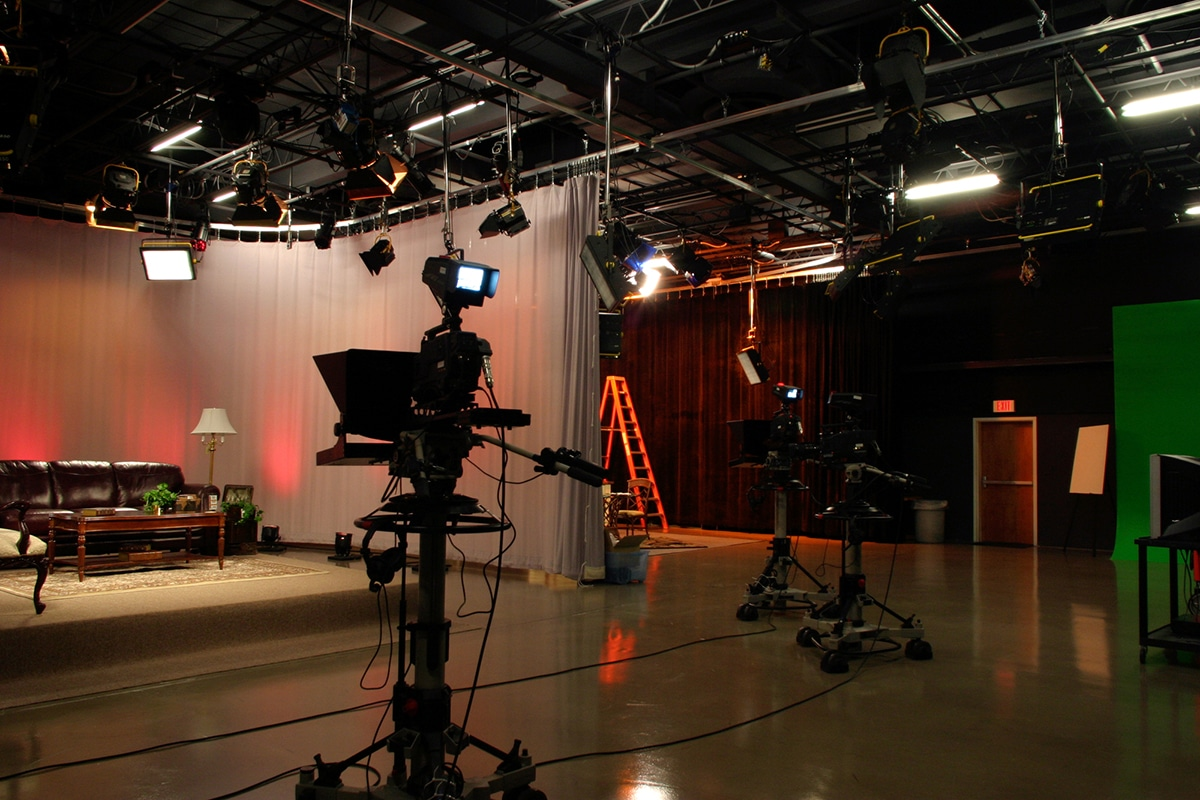

## Overview
Your company is venturing into the movie industry by creating a new movie studio. With the rise of original content creation by major companies, there's an opportunity to tap into this lucrative market. However, your company lacks the necessary insights and expertise in filmmaking. Your task is to analyze current trends in the movie industry, focusing on what type of films are performing best at the box office, and translate these findings into actionable insights for the company's new movie studio.

## Business Problem
Your company now sees all the big companies creating original video content, and they want to get in on the fun. They have decided to create a new movie studio, but the problem is they don’t know anything about creating movies. They have hired you to help them better understand the movie industry. Your team is charged with exploring what type of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

## Data Understanding
In the folder *Data* are movie datasets from:

- Box Office Mojo
- IMDB
- Rotten Tomatoes
- TheMovieDB.org


## Questions to consider
1. What is the best season to release movies vs popularity & domestic gross?
2. What is the most successful genre?
3. Is there a relationship of runtime of movies vs domestic gross and production budget?
4. What are the leading movie studios and production budgets?
5. Can the film industry be a consistent profit center?
6. What is the correlation between vote average and popularity?

## Step 1: Importing packages and loading data

In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis using dataframes
import numpy as np  # For numerical operations and array manipulation
import matplotlib.pyplot as plt  # For creating static, interactive, and animated visualizations in Python
import seaborn as sns  # For making statistical graphics in Python (built on top of matplotlib)

import zipfile  # For unzipping compressed files
import sqlite3  # For connecting to and querying SQLite databases

%matplotlib inline

In [2]:
#Load the CSV files
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='unicode_escape')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='unicode_escape')

In [3]:
#Unzip and load the SQLite Database
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
    z.extractall()
    
conn = sqlite3.connect('im.db')
cursor = conn.cursor()

table_names = pd.read_sql("SELECT name FROM sqlite_master WHERE type = 'table';", conn)
print(table_names)

            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [4]:
#Load the relevant tables from the database
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)

conn.close()

## Step 2: Merge Data Sources

In [5]:
# Merging relevant tables from the sqlite database (movie basics and movie ratings)
movie_basics_and_ratings  = movie_basics.merge(movie_ratings, on = 'movie_id')

# Display the merged data
print(movie_basics_and_ratings.head())

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  averagerating  numvotes  
0        2013            175.0    Action,Crime,Drama            7.0        77  
1        2019            114.0       Biography,Drama            7.2        43  
2        2018            122.0                 Drama            6.9      4517  
3        2018              NaN          Comedy,Drama            6.1        13  
4        2017             80.0  Comedy,Drama,Fantasy            6.5       119  


## Step 3: Data Cleaning

### Cleaning movie_basics_and_ratings dataframe

In [6]:
# Rename columns for readability
movie_basics_and_ratings.rename(columns={
    'primary_title': 'Title', 'runtime_minutes': 'Runtime',
    'genres': 'Genres', 'average_rating': 'AverageRating',
    'num_votes': 'NumVotes'}, inplace=True)

# Drop the original_title column as it is not needed
movie_basics_and_ratings.drop(columns=['original_title'], inplace=True)

# Handle missing values in runtime_minutes by filling them with the mean runtime
movie_basics_and_ratings['Runtime'].fillna(movie_basics_and_ratings['Runtime'].mean(), inplace=True)

# Fill missing values in Genres with 'unknown'
movie_basics_and_ratings['Genres'].fillna('unknown', inplace=True)

# Display the cleaned dataframe
print(movie_basics_and_ratings.head())

    movie_id                            Title  start_year    Runtime  \
0  tt0063540                        Sunghursh        2013  175.00000   
1  tt0066787  One Day Before the Rainy Season        2019  114.00000   
2  tt0069049       The Other Side of the Wind        2018  122.00000   
3  tt0069204                  Sabse Bada Sukh        2018   94.65404   
4  tt0100275         The Wandering Soap Opera        2017   80.00000   

                 Genres  averagerating  numvotes  
0    Action,Crime,Drama            7.0        77  
1       Biography,Drama            7.2        43  
2                 Drama            6.9      4517  
3          Comedy,Drama            6.1        13  
4  Comedy,Drama,Fantasy            6.5       119  


### Cleaning movie_gross dataframe

In [7]:
# Handle missing values
movie_gross.dropna(inplace=True)

# Dropping all rows where the domestic gross, foreign gross and studio is null
movie_gross = movie_gross.dropna(subset=['domestic_gross', 'foreign_gross', 'studio'])

# Rename columns for readability
movie_gross.rename(columns={'title': 'Movie_Title', 'domestic_gross': 'Domestic_Gross',
    'foreign_gross': 'Foreign_Gross', 'studio': 'Studio' }, inplace=True)

# Remove any commas in the Foreign_Gross column and convert to float
movie_gross['Foreign_Gross'] = movie_gross['Foreign_Gross'].str.replace(',', '').astype(float)

movie_gross.head()

,Movie_Title,Studio,Domestic_Gross,Foreign_Gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


### Cleaning tmdb_movies dataframe

In [8]:
# Drop the Unnamed: 0 column as it is not needed
tmdb_movies = tmdb_movies.drop(columns=['Unnamed: 0'])

# Convert release_date to datetime format
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

# Extract day, month, and year from release_date
tmdb_movies['release_day'] = tmdb_movies['release_date'].dt.day
tmdb_movies['release_month'] = tmdb_movies['release_date'].dt.month
tmdb_movies['release_year'] = tmdb_movies['release_date'].dt.year

# Drop the release_date and original_title columns as they are not needed
tmdb_movies = tmdb_movies.drop(columns=['release_date', 'original_title', 'release_day'])

tmdb_movies.rename(columns={'title': 'Movie_Title'}, inplace = True)

# Display the first few rows to check the result
tmdb_movies.head()

,genre_ids,id,original_language,popularity,Movie_Title,vote_average,vote_count,release_month,release_year
0,"[12, 14, 10751]",12444,en,33.533,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11,2010
1,"[14, 12, 16, 10751]",10191,en,28.734,How to Train Your Dragon,7.7,7610,3,2010
2,"[12, 28, 878]",10138,en,28.515,Iron Man 2,6.8,12368,5,2010
3,"[16, 35, 10751]",862,en,28.005,Toy Story,7.9,10174,11,1995
4,"[28, 878, 12]",27205,en,27.920,Inception,8.3,22186,7,2010


### Cleaning movie_budgets dataframe

In [9]:
# Drop the id column as it is not needed
movie_budgets = movie_budgets.drop(columns=['id'])

# Convert release_date to datetime format
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], errors='coerce')

# Drop rows where release_date could not be converted
movie_budgets.dropna(subset=['release_date'], inplace=True)

# Extract day, month, and year from release_date
movie_budgets['release_day'] = movie_budgets['release_date'].dt.day
movie_budgets['release_month'] = movie_budgets['release_date'].dt.month
movie_budgets['release_year'] = movie_budgets['release_date'].dt.year

# Drop the release_date column as it is not needed
movie_budgets = movie_budgets.drop(columns=['release_date', 'release_day'])

# Remove any commas and dollar signs in the budget and gross columns and convert to float
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('[\$,]', '', regex=True).astype(float)
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('[\$,]', '', regex=True).astype(float)
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('[\$,]', '', regex=True).astype(float)

# Rename columns for readability
movie_budgets.rename(columns={
    'movie': 'Movie_Title',
    'production_budget': 'ProductionBudget',
    'domestic_gross': 'DomesticGross',
    'worldwide_gross': 'WorldwideGross'
}, inplace=True)

# Display the first few rows to check the result
movie_budgets.head()

,Movie_Title,ProductionBudget,DomesticGross,WorldwideGross,release_month,release_year
0,Avatar,425000000.0,760507625.0,2.776345e+09,12,2009
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,5,2011
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,6,2019
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,5,2015
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,12,2017


### Cleaning movie_info dataframe

In [10]:
# Handle missing values
movie_info.fillna({'rating': 'unknown',
    'genre': 'unknown',
    'director': 'unknown',
    'writer': 'unknown',
    'studio': 'unknown',
    'currency': '$' }, inplace=True)

# Drop rows where runtime is null
movie_info.dropna(subset=['runtime'], inplace=True)

# Drop unnecessary columns
movie_info = movie_info.drop(columns=['synopsis', 'theater_date', 'dvd_date'])

# Remove any commas and dollar signs in the box_office column and convert to float
movie_info['box_office'] = movie_info['box_office'].str.replace('[\$,]', '', regex=True).astype(float)

# Rename columns for readability
movie_budgets.rename(columns={'runtime': 'runtime_minutes'}, inplace=True)

# Fill null values in box_office with 0
movie_info['box_office'].fillna(0, inplace=True)

# Reset the index to ensure it follows a sequential order
movie_info.reset_index(drop=True, inplace=True)

# Display the first few rows to check the result
movie_info.head()

,id,rating,genre,director,writer,currency,box_office,runtime,studio
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,$,0.0,104 minutes,unknown
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,$,600000.0,108 minutes,Entertainment One
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,$,0.0,116 minutes,unknown
3,6,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,$,0.0,128 minutes,unknown
4,7,NR,Drama|Romance,Rodney Bennett,Giles Cooper,$,0.0,200 minutes,unknown


## Step 4: EDA

### 1.What is the best season to release movies vs popularity/domestic gross?


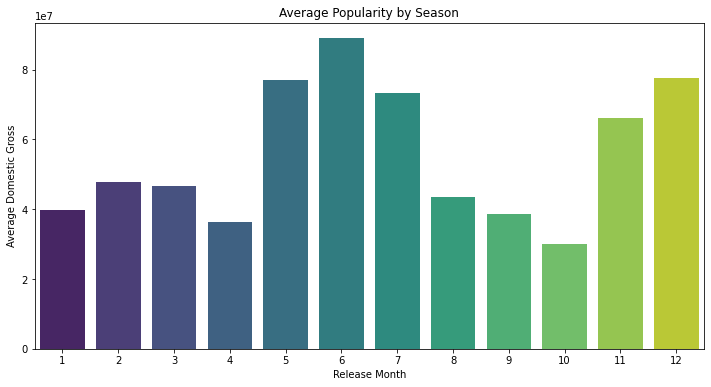

In [11]:
# Merge movie_gross with tmdb_movies on Movie_Title
merged_movies = movie_gross.merge(tmdb_movies, on='Movie_Title')

# Aggregate data to find average Domestic_Gross by release month
avg_domestic_gross_by_month = merged_movies.groupby('release_month')['Domestic_Gross'].mean().reset_index()

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='release_month', y='Domestic_Gross', data=avg_domestic_gross_by_month, palette='viridis')
plt.title('Average Popularity by Season')
plt.xlabel('Release Month')
plt.ylabel('Average Domestic Gross')
plt.show()

Interpretation:

### 2. What is the most successful genre?


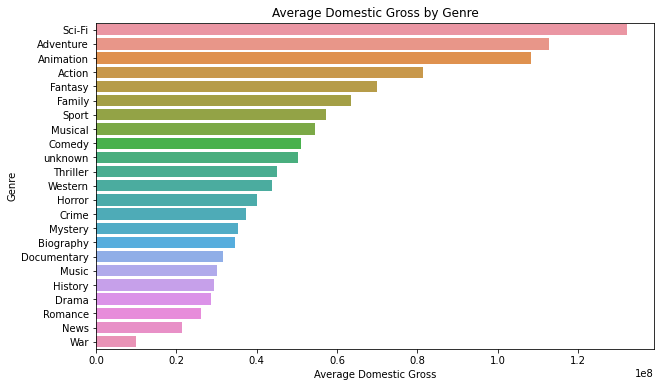

In [15]:
# Extract genres from movie_basics_and_ratings
genres_data = movie_basics_and_ratings['Genres'].str.split(',', expand = True).stack().reset_index(level=1, drop=True)
genres_data.name = 'Genre'

# Merge genres with movie_gross
merged_genres = movie_basics_and_ratings[['Title', 'Genres']].merge(movie_gross, left_on = 'Title', right_on='Movie_Title')

# Explode genres to separate rows
merged_genres = merged_genres.assign(Genres = merged_genres['Genres'].str.split(',')).explode('Genres')

# Calculate average Domestic_Gross per Genre
avg_domestic_gross_by_genre = merged_genres.groupby('Genres')['Domestic_Gross'].mean().reset_index()

# Plot the results
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Domestic_Gross', y = 'Genres', data = avg_domestic_gross_by_genre.sort_values(by = 'Domestic_Gross', ascending=False))
plt.title('Average Domestic Gross by Genre')
plt.xlabel('Average Domestic Gross')
plt.ylabel('Genre')
plt.show()

Interpretation:

### 3. Is there a relationship of runtime of movies vs domestic gross, worldwide gross and production budget?


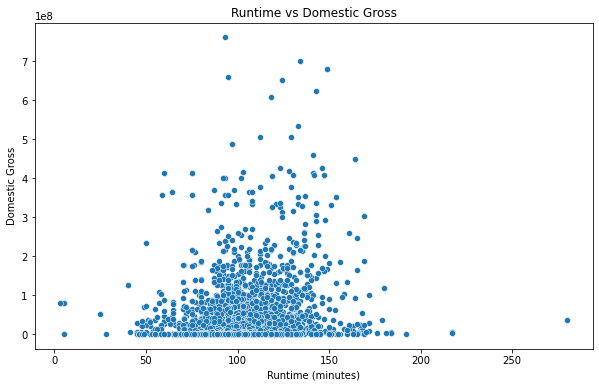

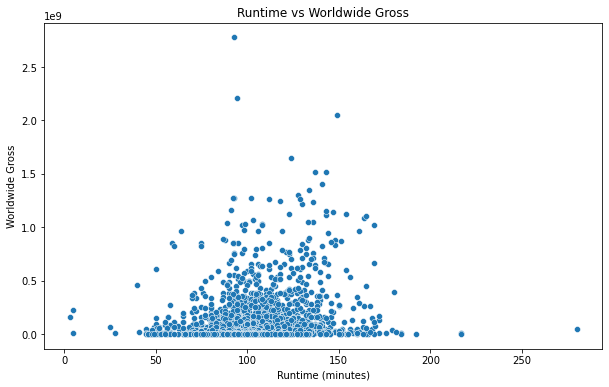

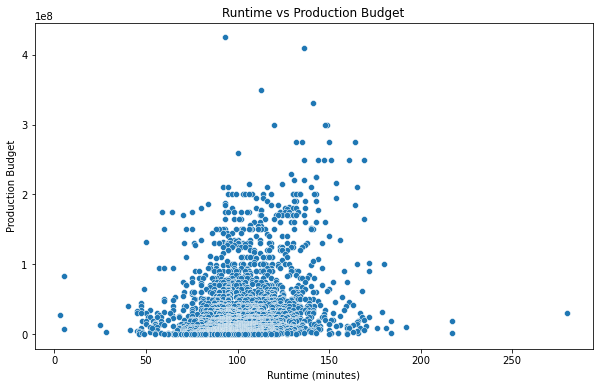

In [16]:
# Merge movie_budgets with movie_basics_and_ratings
merged_budgets_runtime = movie_budgets.merge(movie_basics_and_ratings[['Title', 'Runtime']], left_on='Movie_Title', right_on='Title')

# Plot runtime vs domestic gross
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Runtime', y='DomesticGross', data=merged_budgets_runtime)
plt.title('Runtime vs Domestic Gross')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Domestic Gross')
plt.show()

# Plot runtime vs worldwide gross
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Runtime', y='WorldwideGross', data=merged_budgets_runtime)
plt.title('Runtime vs Worldwide Gross')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Worldwide Gross')
plt.show()

# Plot runtime vs production budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Runtime', y='ProductionBudget', data=merged_budgets_runtime)
plt.title('Runtime vs Production Budget')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Production Budget')
plt.show()

Interpretation:

### 4. What are the leading movie studios and production budgets?


C:\Users\Han\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Han\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Han\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Han\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


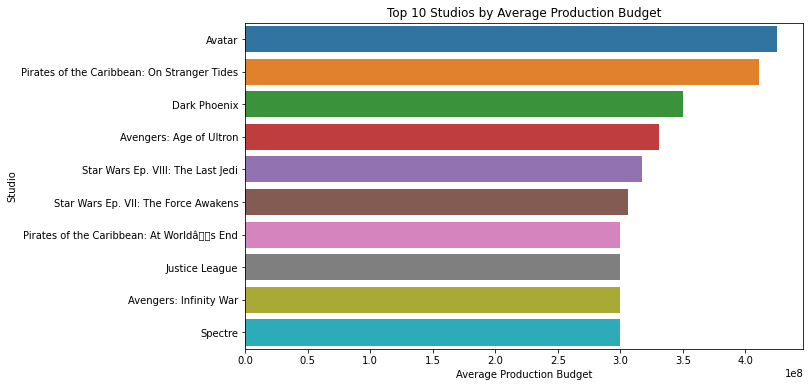

In [17]:
# Calculate average production budget per studio
avg_budget_by_studio = movie_budgets.groupby('Movie_Title')['ProductionBudget'].mean().reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='ProductionBudget', y='Movie_Title', data=avg_budget_by_studio.sort_values(by='ProductionBudget', ascending=False).head(10))
plt.title('Top 10 Studios by Average Production Budget')
plt.xlabel('Average Production Budget')
plt.ylabel('Studio')
plt.show()

Interpretation:

### 5. Profitability Analysis
To evaluate whether the film industry has become more or less profitable, and if higher spending on production affects profitability:

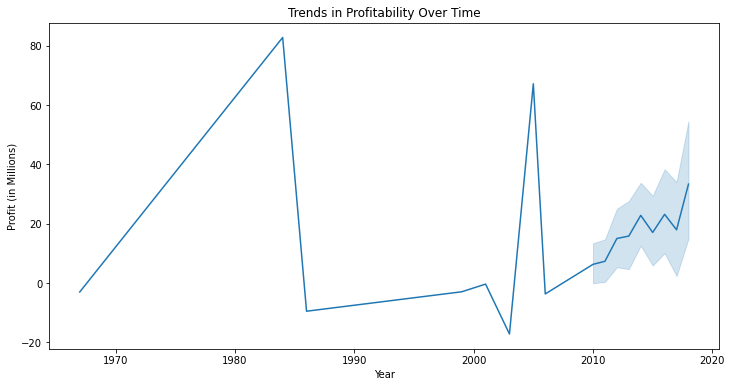

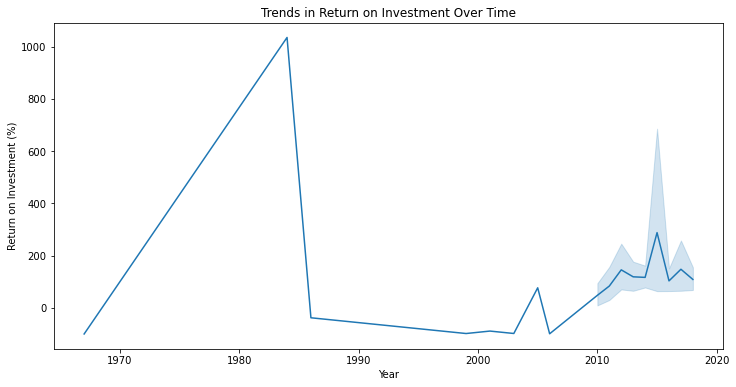

In [22]:
# Combine movie_budgets and movie_gross
combined_df = movie_budgets.merge(movie_gross, on='Movie_Title')

# Add profitability metrics
combined_df['Profit_Millions'] = (combined_df['DomesticGross'] - combined_df['ProductionBudget']) / 1e6
combined_df['ROI'] = ((combined_df['DomesticGross'] - combined_df['ProductionBudget']) / combined_df['ProductionBudget']) * 100

# Plot trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='Profit_Millions', data=combined_df)
plt.title('Trends in Profitability Over Time')
plt.xlabel('Year')
plt.ylabel('Profit (in Millions)')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='ROI', data=combined_df)
plt.title('Trends in Return on Investment Over Time')
plt.xlabel('Year')
plt.ylabel('Return on Investment (%)')
plt.show()

Interpretation:

### 6. Correlation Between Popularity and Vote Average

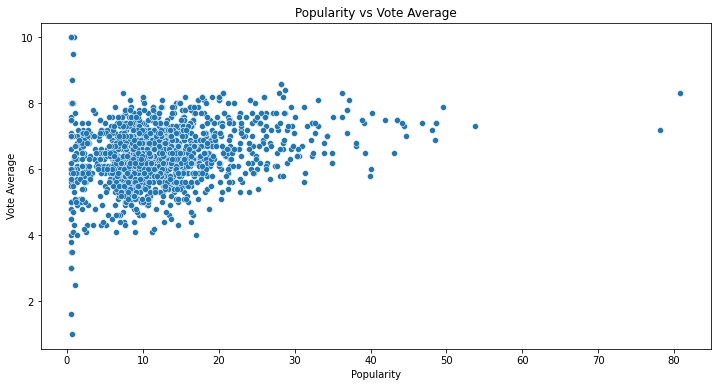

Correlation between Popularity and Vote Average: 0.26761788880889875


In [27]:
# Plot popularity vs vote average
plt.figure(figsize=(12, 6))
sns.scatterplot(x='popularity', y='vote_average', data=merged_movies)
plt.title('Popularity vs Vote Average')
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.show()

# Compute correlation
correlation = merged_movies[['popularity', 'vote_average']].corr().iloc[0, 1]
print(f'Correlation between Popularity and Vote Average: {correlation}')


Interpretation: